In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys, warnings
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from utils import DATA_DIR, ROOT_DIR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings("ignore", category=RuntimeWarning) # supress function fitting warnings
pd.set_option('display.max_columns', None) # display all pandas cols

### Data Decide Evals

In [6]:
from download.hf import pull_predictions_from_hf
from pathlib import Path

local_path = f'{DATA_DIR}/consistent_ranking/data/benchmarks-00000-of-00001.parquet'
df = pd.read_parquet(local_path)
print(f'Loaded {len(df):,} model evaluations')

# Add small model data
local_path = f'{DATA_DIR}/consistent_ranking_small/data/benchmarks-00000-of-00001.parquet'
df_small = pd.read_parquet(local_path)
print(f'Loaded {len(df_small):,} model evaluations')

df = pd.concat([df, df_small], ignore_index=True)

Loaded 201,113 model evaluations
Loaded 61,721 model evaluations


In [4]:
df['mix'] = df['group']

# Only keep the random seeds for fully complete model runs
large_sizes = ['530M', '750M', '1B']
df = pd.concat([
    df[~df['size'].isin(large_sizes)],
    df[(df['size'].isin(large_sizes)) & (df['seed'] == 6198)]
])

In [5]:
MIXES = df['group'].unique()
SIZES = df['size'].unique()
MULT  = df['chinchilla'].unique()
SEEDS = df['seed'].unique()

MODELS = df['model'].unique()
TASKS  = df['task'].unique()

METRICS_RC= [
    'primary_metric', 'correct_prob', 'correct_prob_per_token', 'correct_prob_per_char', 'margin', 'margin_per_token', 'margin_per_char', 'total_prob', 'total_prob_per_token', 'total_prob_per_char', 'uncond_correct_prob', 'uncond_correct_prob_per_token', 'uncond_correct_prob_per_char', 'norm_correct_prob', 'norm_correct_prob_per_token', 'norm_correct_prob_per_char',
    'acc_raw', 'acc_per_token', 'acc_per_char', 'acc_uncond'
]

# Sort SIZES
sizes_numeric = []
for size in SIZES:
    if size.endswith('B'):
        sizes_numeric.append(float(size[:-1]) * 1000)
    else:
        sizes_numeric.append(float(size[:-1]))
SIZES = SIZES[np.argsort(sizes_numeric)]

# Default seed
SEED = 6198

# Default setup
selected_tasks = TASKS
metric = 'primary_metric'
# metric = 'correct_prob_per_char'

### SNR

In [6]:
from dataloader import get_slice
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

metrics_list = []
for task in tqdm(selected_tasks):
    for seed in SEEDS:
        for mix in MIXES:
            for size in SIZES:
                curve_data = get_slice(df, mix=mix, task=task, size=size, seed=seed)
                if curve_data.empty: continue

                curve_data = curve_data.sort_values('step')
                curve_values = curve_data[metric].values
                
                # Compute total variation
                step_changes = np.abs(np.diff(curve_values)).mean()
                first_3_avg = np.mean(curve_values[:3])
                last_3_avg  = np.mean(curve_values[-3:])
                total_variation = step_changes - ((last_3_avg - first_3_avg)/len(curve_values))

                # Calculate standard deviation and count of steps in last X% of checkpoints
                last_vals = curve_values[int(-0.3 * len(curve_values)):]
                step_std = np.std(last_vals)
                step_n = len(last_vals)
                
                # Calculate final score (avg of last X)
                final_score = np.mean(curve_values[int(-0.1 * len(curve_values)):])
                score_last_1 = curve_values[-1]

                # Calculate monotonicity
                steps = np.arange(len(curve_values))
                monotonicity, _ = spearmanr(steps, curve_values)
                
                metrics_list.append({
                    'task': task,
                    'mix': mix,
                    'size': size, 
                    'seed': seed,
                    'score': final_score,
                    'score_last_n': final_score,
                    'score_last_1': score_last_1,
                    'step_std': step_std,
                    'step_n': step_n,
                    'total_variation': total_variation,
                    'monotonicity': monotonicity
                })

metrics_df = pd.DataFrame(metrics_list)

100%|██████████| 11/11 [01:04<00:00,  5.84s/it]


In [7]:
from scipy.stats import pearsonr
from stats import compute_decision_accuracy

# Calculate decision accuracy
mix_order_correlations = []
for seed in SEEDS:
    for task in selected_tasks:
        for size in SIZES:
            score_1b = metrics_df[(metrics_df['task'] == task) & (metrics_df['size'] == '1B')] # only one seed at the target scale
            score_size = metrics_df[(metrics_df['task'] == task) & (metrics_df['size'] == size) & (metrics_df['seed'] == seed)]

            if score_size.empty:
                continue

            # Get the mix orders and scores
            score_1b_sorted   = score_1b.sort_values('score', ascending=False).reset_index(drop=True)
            score_size_sorted = score_size.sort_values('score', ascending=False).reset_index(drop=True)
            mixes_1b          = score_1b_sorted['mix'].tolist()
            mixes_size        = score_size_sorted['mix'].tolist()
            scores_1b         = score_1b_sorted['score'].tolist()
            scores_size       = score_size_sorted['score'].tolist()
            decision_accuracy = compute_decision_accuracy(mixes_1b, mixes_size)
            
            # Calculate Pearson correlation
            common_mixes       = list(set(mixes_1b) & set(mixes_size))
            scores_1b_common   = [scores_1b[mixes_1b.index(mix)] for mix in common_mixes]
            scores_size_common = [scores_size[mixes_size.index(mix)] for mix in common_mixes]
            pearson_corr, _    = pearsonr(scores_1b_common, scores_size_common)

            mix_order_correlations.append({
                'task': task,
                'size': size,
                'seed': seed,
                'mix_order_correlation': decision_accuracy,
                'mix_order_pearson_correlation': pearson_corr,
            })

# Add to metrics_df
correlation_df = pd.DataFrame(mix_order_correlations)
metrics_df = metrics_df.merge(correlation_df, on=['task', 'size', 'seed'], how='left', suffixes=('_y', ''))
metrics_df = metrics_df.drop([col for col in metrics_df.columns if col.endswith('_y')], axis=1)

In [8]:
# Calculate aggregated stats
agg_stats = metrics_df.groupby(['task', 'size', 'seed'])['score'].agg([
    'mean',
    'std'
]).reset_index()

# Calculate range and z-score separately to ensure proper aggregation
range_stats = metrics_df.groupby(['task', 'size', 'seed'])['score'].agg(
    range=lambda x: x.max() - x.min()
).reset_index()

metrics_df = metrics_df.merge(agg_stats, on=['task', 'size', 'seed'], how='left')
metrics_df = metrics_df.merge(range_stats, on=['task', 'size', 'seed'], how='left')

metrics_df['z_score'] = metrics_df.groupby(['task', 'size', 'seed'])['score'].transform(
    lambda x: (x - x.mean()) / x.std()
)

sizes = metrics_df['size'].unique()

In [9]:
from utils.aggregation_functions import AGGREGATION_FUNCTIONS
from matplotlib.pylab import LinAlgError
import scipy

def get_r2_for_aggregation(x_vals, y_vals):
    """Get R^2 value for a given aggregation"""
    x_log = np.log10(x_vals)
    r = np.corrcoef(x_log, y_vals)[0,1]
    r2 = r**2
    return r2

# Calculate R^2 for each aggregation
results = []
for func_dict in AGGREGATION_FUNCTIONS:
    agg_func = func_dict['func']
    title = func_dict['title']
    latex = func_dict['latex']
    signal_xlabel = func_dict['signal_xlabel']

    snr_values = []
    decision_accuracies = []
    
    for size in sizes:
        for task in metrics_df['task'].unique():
            if task == 'olmes_10_macro_avg':
                continue
                
            mix_data = metrics_df[(metrics_df['task'] == task) & (metrics_df['size'] == size)]

            step_noise  = mix_data['step_std'] # step-to-step std dev
            data_scores = mix_data['score_last_1'].values # data final ckpt score
            data_noise  = mix_data['std'] # data step-to-step std dev
            data_scores_last_n = mix_data['score_last_n'] # data avg of last n scores

            signal, noise, snr = agg_func(
                step_noise,
                data_scores,
                data_noise,
                data_scores_last_n,
            )
            decision_accuracy = np.mean(mix_data['mix_order_correlation'])
            
            snr_values.append(snr)
            decision_accuracies.append(decision_accuracy)
    
    try:
        r2 = get_r2_for_aggregation(snr_values, decision_accuracies)
    except LinAlgError as e:
        r2 = float('-inf') # if the fit fails, no r2
    
    results.append((title, latex, r2))

results_df = pd.DataFrame(results, columns=['Aggregation Method', '', 'SNR R²'])
results_df = results_df.sort_values('SNR R²', ascending=False)
results_df = results_df.set_index('Aggregation Method')
results_df['SNR R²'] = results_df['SNR R²'].apply(lambda x: '{:.4f}'.format(x))


print(results_df.style.to_latex(
    column_format='lll',
    position='h',
    position_float='centering',
    caption='SNR Variant Results',
    label='tab:snr_variants'
))

\begin{table}[h]
\centering
\caption{SNR Variant Results}
\label{tab:snr_variants}
\begin{tabular}{lll}
 &  & SNR R² \\
Aggregation Method &  &  \\
Distance Standard Deviation & $\frac{1}{n}\sum_i (c_i - \bar{c})$ & 0.0237 \\
Star Discrepancy (Shift+Scale) & $\sup_{[0,c]} |F_n(t) - F(t)|$ with shifting & 0.0216 \\
RMS Deviation & $\sqrt{\frac{1}{n}\sum_i (c_i - \bar{c})^2}$ & 0.0183 \\
Average Absolute Deviation & $\frac{1}{n}\sum_i |c_i - \bar{c}|$ & 0.0166 \\
Mean Pairwise Distance & $\frac{1}{n^2}\sum_{i,j} |c_i - c_j|$ & 0.0154 \\
Robust Range & $P_{95} - P_5$ & 0.0149 \\
Mean Squared Pairwise Distance & $\frac{1}{n^2}\sum_{i,j} (c_i - c_j)^2$ & 0.0137 \\
Dispersion & $\max_{i,j} |c_i - c_j|$ & 0.0064 \\
Range & $\max(c) - \min(c)$ & 0.0064 \\
Gini Coefficient & $\frac{1}{2n^2\mu}\sum_{i,j} |c_i - c_j|$ & 0.0062 \\
Dispersion (Shift+Scale) & $\max_{i,j} |c_i - c_j|$ with shifting & 0.0059 \\
Quartile Deviation & $(Q_3 - Q_1)/2$ & 0.0049 \\
Rel. Std. Dev. & $\sigma/\mu$ & 0.0042 \\


/var/folders/cr/z51hvhb932vbx29jw5hxd9nh0000gn/T/ipykernel_72073/1430489876.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncols=2, title='Model Size',


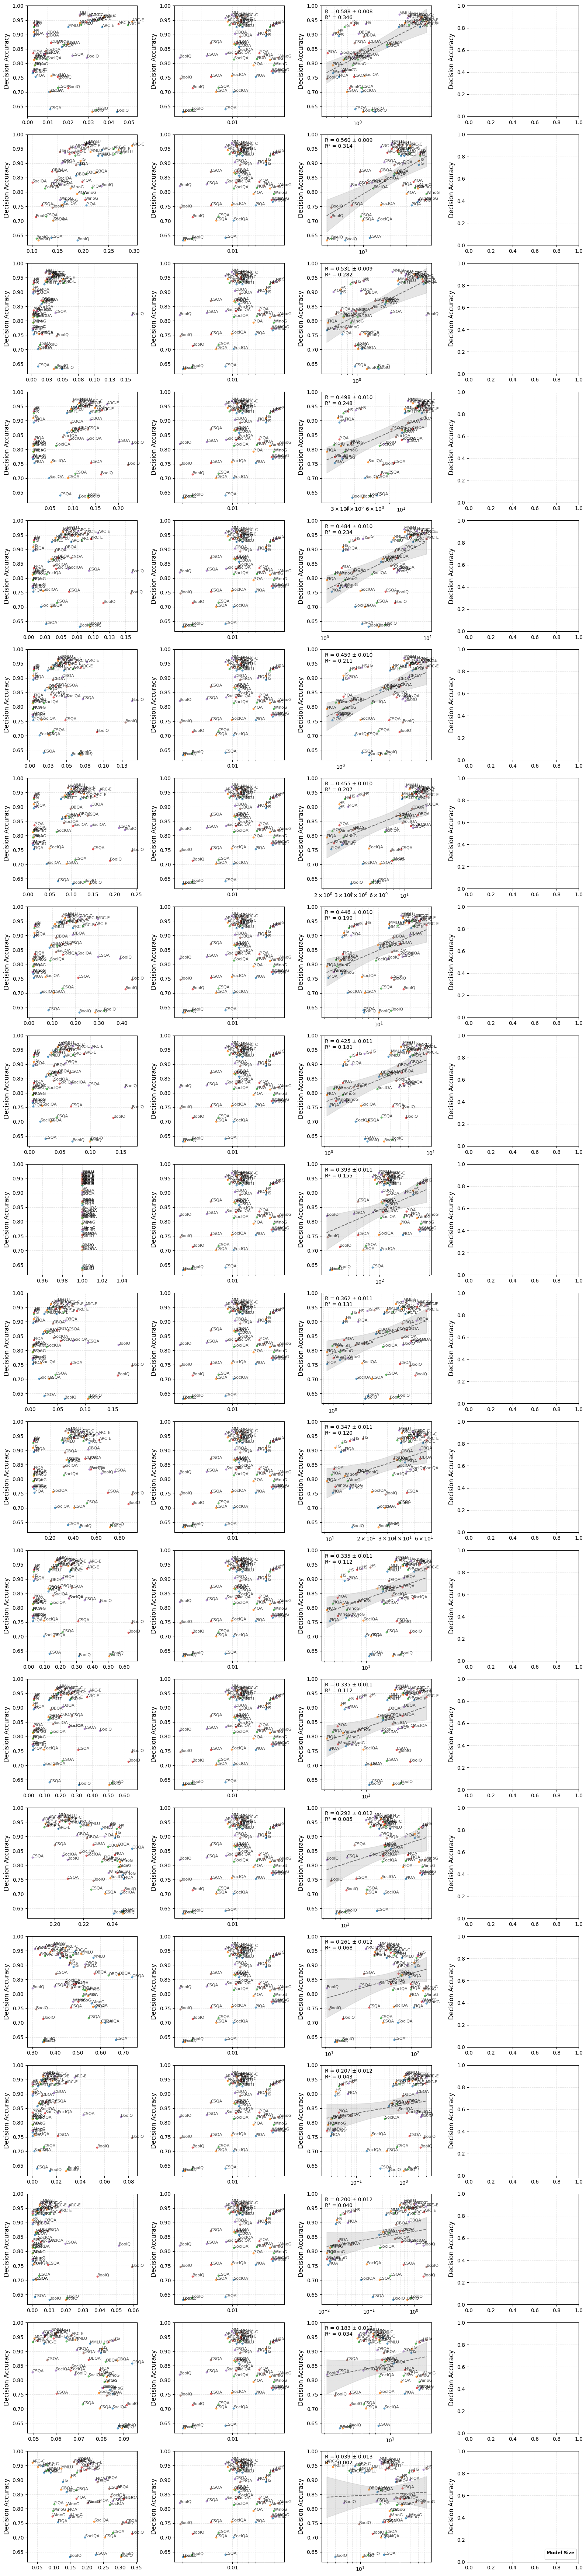

In [11]:
from matplotlib import ticker
import numpy as np
import matplotlib.pyplot as plt
from plot_snr import create_scatter_plot, configure_axis
from utils import PLOT_DIR

def plot_snr_variants(aggregation_functions, plot_only_snr=False):
    # Calculate R² values and sort aggregation methods
    r2_values = []
    for func_dict in aggregation_functions:
        agg_func = func_dict['func']

        snr_values = []
        decision_accuracies = []
        
        for size in SIZES[7:-1]:
            for task in metrics_df['task'].unique():
                if task == 'olmes_10_macro_avg':
                    continue
                    
                mix_data = metrics_df[(metrics_df['task'] == task) & (metrics_df['size'] == size)]
                
                _, _, snr = agg_func(
                    mix_data['step_std'],
                    mix_data['score_last_1'].values,
                    mix_data['std'],
                    mix_data['score_last_n']
                )
                decision_accuracies.append(np.mean(mix_data['mix_order_correlation']))
                snr_values.append(snr)
        
        try:
            r2 = get_r2_for_aggregation(snr_values, decision_accuracies)
        except LinAlgError:
            r2 = float('-inf')
        r2_values.append((func_dict, r2))
    
    r2_values.sort(key=lambda x: x[1], reverse=True)
    sorted_aggregation_functions = [func_dict for func_dict, r2 in r2_values]

    # Set up plot grid
    n_rows = len(sorted_aggregation_functions) if not plot_only_snr else (len(sorted_aggregation_functions)-1)//4 + 1
    n_cols = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5*n_rows))
    axes = axes.reshape(n_rows, n_cols)

    task_names = {
        'arc_challenge': 'ARC-C', 'arc_easy': 'ARC-E', 'boolq': 'BoolQ',
        'csqa': 'CSQA', 'hellaswag': 'HS', 'openbookqa': 'OBQA',
        'piqa': 'PIQA', 'socialiqa': 'SocIQA', 'winogrande': 'WinoG',
        'mmlu': 'MMLU', 'olmes_10_macro_avg': 'OLMES-10'
    }

    # Initialize data storage
    all_data = {ax: {'x': [], 'y': [], 'texts': []} for row in axes for ax in row}

    # Collect and plot data
    for size in SIZES[7:-1]:
        size_data = {ax: {'x': [], 'y': [], 'tasks': []} for row in axes for ax in row}
        
        for task in metrics_df['task'].unique():
            if task == 'olmes_10_macro_avg':
                continue
                
            mix_data = metrics_df[(metrics_df['task'] == task) & (metrics_df['size'] == size)]
            decision_accuracy = np.mean(mix_data['mix_order_correlation'])
            
            for idx, func_dict in enumerate(sorted_aggregation_functions):
                agg_func = func_dict['func']
                
                row_idx = idx // 4 if plot_only_snr else idx
                col_idx = idx % 4 if plot_only_snr else 2
                
                if plot_only_snr and row_idx >= n_rows:
                    continue

                signal, noise, snr = agg_func(
                    mix_data['step_std'],
                    mix_data['score_last_1'].values,
                    mix_data['std'],
                    mix_data['score_last_n']
                )
                
                ax = axes[row_idx][col_idx]
                size_data[ax]['x'].append(snr)
                size_data[ax]['y'].append(decision_accuracy)
                size_data[ax]['tasks'].append(task)
                all_data[ax]['x'].append(snr)
                all_data[ax]['y'].append(decision_accuracy)

                if not plot_only_snr:
                    # Add signal and noise plots
                    for i, val in enumerate([signal, noise]):
                        ax = axes[row_idx][i]
                        size_data[ax]['x'].append(val)
                        size_data[ax]['y'].append(decision_accuracy) 
                        size_data[ax]['tasks'].append(task)
                        all_data[ax]['x'].append(val)
                        all_data[ax]['y'].append(decision_accuracy)

        # Create scatter plots
        for row in axes:
            for ax in row:
                data = size_data[ax]
                if data['x']:
                    texts = create_scatter_plot(ax, data['x'], data['y'], data['tasks'], size, task_names)
                    all_data[ax]['texts'].extend(texts)

    # Configure axes
    for idx, func_dict in enumerate(sorted_aggregation_functions):
        title = func_dict['title']
        snr_xlabel = func_dict['snr_xlabel']

        row_idx = idx // 4 if plot_only_snr else idx
        if plot_only_snr and row_idx >= n_rows:
            continue
            
        if plot_only_snr:
            ax = axes[row_idx][idx % 4]
            configure_axis(ax, all_data[ax]['x'], all_data[ax]['y'],
                           all_data[ax]['texts'], '', True, False)
            ax.set_xscale('log')

            ax.set_title(title, fontsize=12)
            ax.set_xlabel(snr_xlabel, fontsize=12)
        else:
            for col_idx, ax in enumerate(axes[idx]):
                configure_axis(ax, all_data[ax]['x'], all_data[ax]['y'],
                               all_data[ax]['texts'], '', 
                               col_idx == 2, col_idx == 1)
                               
                
                if col_idx == 1:
                    ax.invert_xaxis()
                if col_idx == 2:
                    ax.set_xscale('log')

        # Format axis ticks and add legend to last plot
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())
        
        is_last = (idx == len(sorted_aggregation_functions)-1)
        if is_last:
            ax.legend(ncols=2, title='Model Size',
                     title_fontproperties={'weight': 'bold', 'size': 9},
                     fontsize=9, loc='lower right')

    plt.tight_layout()
    plt.savefig(f'{PLOT_DIR}/snr_variants{"_snr_only" if plot_only_snr else ""}.pdf', bbox_inches='tight')
    plt.show()

plot_snr_variants(AGGREGATION_FUNCTIONS)
# plot_snr_variants(AGGREGATION_FUNCTIONS, plot_only_snr=True)